# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import time
import string
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import tweepy
from tweepy import OAuthHandler 
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already u

# Selenium Driver to scrap Tweets

In [2]:
class SeleniumClient(object):
    
    def __init__(self):

        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_argument('--headless')
        self.chrome_options.add_argument('--no-sandbox')
        self.chrome_options.add_argument('--disable-setuid-sandbox')


        self.browser = webdriver.Chrome('D:\Data Science Python Programs\TWEET SENTIMENT ANALYSIS', options=self.chrome_options)

        self.base_url = 'https://twitter.com/search?q=Deep%20Learning&src=typed_query'

    def get_tweets(self, query):
 
        try: 
            self.browser.get(self.base_url+query)
            time.sleep(2)

            body = self.browser.find_element_by_tag_name('AI')

            for _ in range(3000):
                body.send_keys(Keys.PAGE_DOWN)
                time.sleep(0.3)

            timeline = self.browser.find_element_by_id('Deep-Learning')
            tweet_nodes = timeline.find_elements_by_css_selector('.tweet-text')

            return pd.DataFrame({'tweets': [tweet_node.text for tweet_node in tweet_nodes]})

        except:
            print("Selenium - An error occured while fetching tweets.")

# Twitter API Keys

In [3]:
consumer_key = 'bfJFUcjt327hIBHF8vNjCl5kH'
consumer_secret = 'l2EPpOEEYDKoW2IgtmAZB8NmKB6fGfxEE0LU9bHVO4M6r5Exi1'
access_token = '1286676198957805568-13YOgFwtZ3J46enPx2RpE1HcC9D7QD'
access_token_secret = 'X56XJtWhu33MLuUVI1qJbN0eSk5RQusKYLAfCX9M6ivW2'

# Tweepy OAuthHandler for Tweets Extraction

In [4]:
class TwitterClient(object): 
    
    
    def __init__(self): 
  
        try: 
     
            auth = OAuthHandler(consumer_key, consumer_secret) 
      
            auth.set_access_token(access_token, access_token_secret) 
            
            
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 5000):
       
    
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 


                    if tweet.retweet_count > 0: 

                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:

                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [5]:
twitter_client = TwitterClient()


tweets_df = twitter_client.get_tweets('AI and Deep learning', maxTweets=7000)
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
Downloaded 1100 tweets
Downloaded 1200 tweets
Downloaded 1300 tweets
Downloaded 1400 tweets
Downloaded 1500 tweets
Downloaded 1600 tweets
Downloaded 1700 tweets
Downloaded 1800 tweets
Downloaded 1900 tweets
Downloaded 2000 tweets
Downloaded 2100 tweets
Downloaded 2200 tweets
Downloaded 2300 tweets
Downloaded 2400 tweets
Downloaded 2500 tweets
Downloaded 2597 tweets
Downloaded 2697 tweets
Downloaded 2797 tweets
Downloaded 2897 tweets
Downloaded 2997 tweets
Downloaded 3097 tweets
Downloaded 3144 tweets
No more tweets found
tweets_df Shape - (1252, 1)


,tweets
0,RT @ipfconline1: #DeepLearning in Natural Lang...
1,RT @D2L_ai: Dive into Deep Learning v0.15.0 is...
2,Tweets Scrapped from Twitter API and performed...
3,"RT @analyticbridge: A simple guide to AI, Mach..."
4,RT @hackermaderas: #CyberpunkisNow YouTuber Co...
5,RT @sjoerdapp: 🐱🐶🐱 Best of https://t.co/cXLlhp...
6,"🐱🐶🐱 Best of https://t.co/cXLlhpkfdJ for AI, Ma..."
7,🐱🐶🐱 Decoding COVID-19 pneumonia: comparison of...
8,RT @Analytics_699: Extract Key-Value pair by L...
9,RT @360digitmg_MY: Game-changing innovations b...


# Sentiment Polarity Using TextBlob

In [6]:
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [7]:
sentiments_using_SIA = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,tweets
pos,1183
neg,69


In [8]:
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,1096
neg,156


In [9]:
tweets_df['sentiment'] = sentiments_using_textblob
tweets_df.head()

,tweets,sentiment
0,RT @ipfconline1: #DeepLearning in Natural Lang...,pos
1,RT @D2L_ai: Dive into Deep Learning v0.15.0 is...,pos
2,Tweets Scrapped from Twitter API and performed...,pos
3,"RT @analyticbridge: A simple guide to AI, Mach...",pos
4,RT @hackermaderas: #CyberpunkisNow YouTuber Co...,pos


# Text Preproccessing

In [10]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [11]:
# tweets_df['tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
tweets_df =tweets_df.applymap(lambda s:s.lower() if type(s) == str else s)
tweets_df.head(10)

,tweets,sentiment
0,rt @ipfconline1: #deeplearning in natural lang...,pos
1,rt @d2l_ai: dive into deep learning v0.15.0 is...,pos
2,tweets scrapped from twitter api and performed...,pos
3,"rt @analyticbridge: a simple guide to ai, mach...",pos
4,rt @hackermaderas: #cyberpunkisnow youtuber co...,pos
5,rt @sjoerdapp: 🐱🐶🐱 best of https://t.co/cxllhp...,pos
6,"🐱🐶🐱 best of https://t.co/cxllhpkfdj for ai, ma...",pos
7,🐱🐶🐱 decoding covid-19 pneumonia: comparison of...,pos
8,rt @analytics_699: extract key-value pair by l...,pos
9,rt @360digitmg_my: game-changing innovations b...,pos


In [12]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment
0,rt @ipfconline1: #deeplearning in natural lang...,pos
1,rt @d2l_ai: dive into deep learning v0.15.0 is...,pos
2,tweets scrapped from twitter api and performed...,pos
3,"rt @analyticbridge: a simple guide to ai, mach...",pos
4,rt @hackermaderas: #cyberpunkisnow youtuber co...,pos
5,"rt @sjoerdapp: 🐱🐶🐱 best of for ai, machine lea...",pos
6,"🐱🐶🐱 best of for ai, machine learning, and deep...",pos
7,🐱🐶🐱 decoding covid-19 pneumonia: comparison of...,pos
8,rt @analytics_699: extract key-value pair by l...,pos
9,rt @360digitmg_my: game-changing innovations b...,pos


In [13]:
tweets_df = tweets_df[tweets_df['tweets']!='']
tweets_df.head()

,tweets,sentiment
0,rt @ipfconline1: #deeplearning in natural lang...,pos
1,rt @d2l_ai: dive into deep learning v0.15.0 is...,pos
2,tweets scrapped from twitter api and performed...,pos
3,"rt @analyticbridge: a simple guide to ai, mach...",pos
4,rt @hackermaderas: #cyberpunkisnow youtuber co...,pos


In [14]:
tweets_df.drop_duplicates(subset=['tweets'], keep=False)
tweets_df = tweets_df.reset_index(drop=True)
tweets_df['tweets'] = tweets_df['tweets'].str.replace("[^a-zA-Z# ]", "")
tweets_df.head()

,tweets,sentiment
0,rt ipfconline #deeplearning in natural languag...,pos
1,rt dlai dive into deep learning v is released ...,pos
2,tweets scrapped from twitter api and performed...,pos
3,rt analyticbridge a simple guide to ai machine...,pos
4,rt hackermaderas #cyberpunkisnow youtuber code...,pos


In [15]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment
0,rt ipfconline natural language processing hist...,pos
1,rt dlai dive deep learning v released chapters...,pos
2,tweets scrapped twitter api performed sentimen...,pos
3,rt analyticbridge simple guide ai machine lear...,pos
4,rt hackermaderas youtuber code bullet taught a...,pos
5,rt sjoerdapp best ai machine learning deep lea...,pos
6,best ai machine learning deep learning septemb...,pos
7,decoding covid pneumonia comparison deep learn...,pos
8,rt analytics extract keyvalue pair lstm,pos
9,rt digitmgmy gamechanging innovations begin kn...,pos


In [16]:
tokenized_tweet = tweets_df['tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [rt, ipfconline, natural, language, processing...
1    [rt, dlai, dive, deep, learning, v, released, ...
2    [tweets, scrapped, twitter, api, performed, se...
3    [rt, analyticbridge, simple, guide, ai, machin...
4    [rt, hackermaderas, youtuber, code, bullet, ta...
Name: tweets, dtype: object

In [17]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [rt, ipfconline, natural, language, processing...
1    [rt, dlai, dive, deep, learning, v, released, ...
2    [tweet, scrapped, twitter, api, performed, sen...
3    [rt, analyticbridge, simple, guide, ai, machin...
4    [rt, hackermaderas, youtuber, code, bullet, ta...
Name: tweets, dtype: object

In [18]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,sentiment
0,rt ipfconline natural language processing hist...,pos
1,rt dlai dive deep learning v released chapter ...,pos
2,tweet scrapped twitter api performed sentiment...,pos
3,rt analyticbridge simple guide ai machine lear...,pos
4,rt hackermaderas youtuber code bullet taught a...,pos
5,rt sjoerdapp best ai machine learning deep lea...,pos
6,best ai machine learning deep learning septemb...,pos
7,decoding covid pneumonia comparison deep learn...,pos
8,rt analytics extract keyvalue pair lstm,pos
9,rt digitmgmy gamechanging innovation begin kno...,pos


In [19]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

In [20]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [21]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['ipfconline natural language', 'history achievement exxactcorp'],
 ['dlai dive deep learning', 'chapter pytorch', 'chapter close adop'],
 ['tweet', 'api', 'sentiment analysis', 'deep learning', 'rnn lstm'],
 ['analyticbridge simple guide', 'machine', 'deep learning'],
 ['hackermaderas',
  'code bullet taught',
  'play',
  'deep learning',
  'neural network genetic'],
 ['sjoerdapp', 'machine', 'deep learning september insidebigdata'],
 ['machine', 'deep learning september insidebigdata'],
 ['covid pneumonia comparison deep learning radiomics',
  'image signature',
  'news'],
 ['analytics extract keyvalue pair lstm'],
 ['digitmgmy', 'innovation begin', 'course']]

In [22]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():

    words_without_hash = [word for word in row.tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['rt ipfconline natural language processing history achievement v exxactcorp'],
 ['rt dlai dive deep',
  'v released chapter pytorch tensorflow chapter',
  'v adop'],
 ['tweet scrapped twitter api', 'sentiment analysis', 'rnn lstm'],
 ['rt analyticbridge simple guide'],
 ['rt hackermaderas youtuber code bullet', 'neural network genetic al'],
 ['rt sjoerdapp best', 'september insidebigdata'],
 ['september insidebigdata'],
 ['covid pneumonia comparison deep',
  'radiomics ct image signature docwire news'],
 ['keyvalue pair lstm'],
 ['rt digitmgmy']]

In [23]:
tweets_df['key_phrases'] = textblob_key_phrases
tweets_df.head(10)

,tweets,sentiment,key_phrases
0,rt ipfconline natural language processing hist...,pos,[rt ipfconline natural language processing his...
1,rt dlai dive deep learning v released chapter ...,pos,"[rt dlai dive deep, v released chapter pytorch..."
2,tweet scrapped twitter api performed sentiment...,pos,"[tweet scrapped twitter api, sentiment analysi..."
3,rt analyticbridge simple guide ai machine lear...,pos,[rt analyticbridge simple guide]
4,rt hackermaderas youtuber code bullet taught a...,pos,"[rt hackermaderas youtuber code bullet, neural..."
5,rt sjoerdapp best ai machine learning deep lea...,pos,"[rt sjoerdapp best, september insidebigdata]"
6,best ai machine learning deep learning septemb...,pos,[september insidebigdata]
7,decoding covid pneumonia comparison deep learn...,pos,"[covid pneumonia comparison deep, radiomics ct..."
8,rt analytics extract keyvalue pair lstm,pos,[keyvalue pair lstm]
9,rt digitmgmy gamechanging innovation begin kno...,pos,[rt digitmgmy]


# WordCloud Generation

In [24]:
from wordcloud import WordCloud
def wordcloud(x):
    plt.figure(figsize=(14, 10))
    wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(x))
    plt.imshow(wordcloud)
    plt.axis("off")
    return wordcloud

In [25]:
all_words = ' '.join([text for text in tweets_df['tweets'][tweets_df.sentiment == 'pos']])

In [26]:
all_wordss = all_words.split()

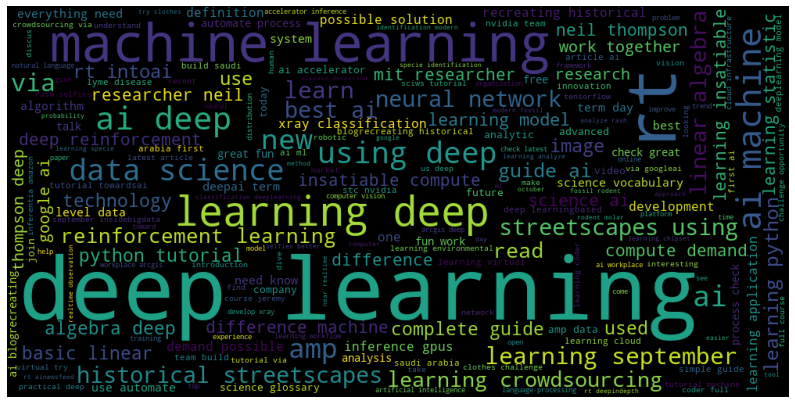

In [27]:
wordcloud(all_wordss)

In [28]:
tweets_df2 = tweets_df[tweets_df['key_phrases'].str.len()>0]

In [29]:
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df2['tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df2['tweets'])

In [30]:
phrase_sents = tweets_df2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

In [31]:
target_variable = tweets_df2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [32]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()
    
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

Accuracy Score - 0.9080459770114943


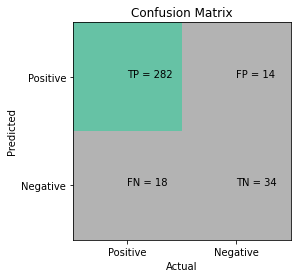

In [33]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.9080459770114943


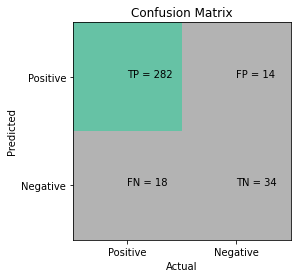

In [34]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.8390804597701149


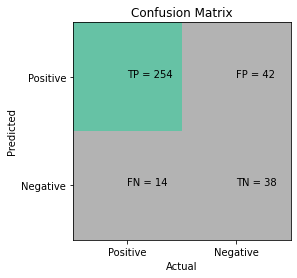

In [35]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

In [36]:
tweets_df = tweets_df[['tweets','sentiment']]
tweets_df['sentiment'] = np.where(tweets_df['sentiment'] == 'pos', 1, 0)
tweets_df.head()

,tweets,sentiment
0,rt ipfconline natural language processing hist...,1
1,rt dlai dive deep learning v released chapter ...,1
2,tweet scrapped twitter api performed sentiment...,1
3,rt analyticbridge simple guide ai machine lear...,1
4,rt hackermaderas youtuber code bullet taught a...,1


In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets_df['tweets'], tweets_df['sentiment'], \
                                                    test_size=0.1, random_state=0)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1125,), (125,), (1125,), (125,))

# Recurrent Neural Network Modeling with LSTM

In [115]:
top_words = 40000
maxlen = 120 
batch_size = 64
nb_epoch = 200

In [62]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.models import Sequential

tokenizer = Tokenizer(nb_words=top_words) #only consider top 40000 words in the corpse
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)
y_train_seq = np_utils.to_categorical(y_train, 6)
y_test_seq = np_utils.to_categorical(y_test, 6)

In [63]:
X_train_seq.shape,X_test_seq.shape,y_train_seq.shape,y_test_seq.shape

((1125, 120), (125, 120), (1125, 6), (125, 6))

In [116]:
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

def build_rnn(top_words,max_len):
    
    model = Sequential([
        
        keras.layers.Embedding(top_words, 128),
        
        keras.layers.LSTM(256),
        keras.layers.Dropout(0.4),

        keras.layers.Dense(128),
        keras.layers.Dropout(0.4),


        keras.layers.Dense(90),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(75),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(64),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(60),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(45),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(40),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(32),
        keras.layers.Dropout(0.1),


        keras.layers.Dense(6, activation='sigmoid'),


         ])

    return model

rnn_model = build_rnn(top_words, 128)

rnn_model.summary()

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])



Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 128)         5120000   
_________________________________________________________________
lstm_26 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dropout_184 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_215 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_185 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 90)                11610     
_________________________________________________________________
dropout_186 (Dropout)        (None, 90)              

In [117]:
rnn_model.fit(X_train_seq, y_train_seq, batch_size=batch_size,epochs=nb_epoch, verbose=1)

Epoch 1/200
18/18 [==============================] - 13s 742ms/step - loss: 0.4267 - acc: 0.7218
Epoch 2/200
18/18 [==============================] - 13s 705ms/step - loss: 0.1766 - acc: 0.8667
Epoch 3/200
18/18 [==============================] - 13s 721ms/step - loss: 0.1184 - acc: 0.8738
Epoch 4/200
18/18 [==============================] - 14s 769ms/step - loss: 0.1016 - acc: 0.8800
Epoch 5/200
18/18 [==============================] - 14s 780ms/step - loss: 0.0852 - acc: 0.8800
Epoch 6/200
18/18 [==============================] - 14s 762ms/step - loss: 0.0720 - acc: 0.8996
Epoch 7/200
18/18 [==============================] - 13s 731ms/step - loss: 0.0504 - acc: 0.9458
Epoch 8/200
18/18 [==============================] - 13s 700ms/step - loss: 0.0217 - acc: 0.9929
Epoch 9/200
18/18 [==============================] - 14s 766ms/step - loss: 0.0167 - acc: 0.9929
Epoch 10/200
18/18 [==============================] - 14s 757ms/step - loss: 0.0258 - acc: 0.9893
Epoch 11/200
18/18 [=========

18/18 [==============================] - 13s 699ms/step - loss: 0.0047 - acc: 1.0000
Epoch 85/200
18/18 [==============================] - 13s 695ms/step - loss: 0.0088 - acc: 0.9964
Epoch 86/200
18/18 [==============================] - 13s 729ms/step - loss: 0.0040 - acc: 0.9991
Epoch 87/200
18/18 [==============================] - 14s 751ms/step - loss: 0.0020 - acc: 0.9973
Epoch 88/200
18/18 [==============================] - 13s 718ms/step - loss: 0.0042 - acc: 0.9982
Epoch 89/200
18/18 [==============================] - 13s 702ms/step - loss: 0.0110 - acc: 0.9929
Epoch 90/200
18/18 [==============================] - 14s 756ms/step - loss: 0.0051 - acc: 0.9973
Epoch 91/200
18/18 [==============================] - 13s 739ms/step - loss: 0.0091 - acc: 0.9956
Epoch 92/200
18/18 [==============================] - 13s 743ms/step - loss: 0.0042 - acc: 0.9991
Epoch 93/200
18/18 [==============================] - 12s 683ms/step - loss: 0.0073 - acc: 0.9956
Epoch 94/200
18/18 [=============

18/18 [==============================] - 12s 681ms/step - loss: 2.6310e-04 - acc: 1.0000
Epoch 167/200
18/18 [==============================] - 8s 441ms/step - loss: 1.1121e-04 - acc: 1.0000
Epoch 168/200
18/18 [==============================] - 9s 477ms/step - loss: 0.0016 - acc: 0.9982
Epoch 169/200
18/18 [==============================] - 8s 455ms/step - loss: 1.8464e-05 - acc: 1.0000
Epoch 170/200
18/18 [==============================] - 8s 452ms/step - loss: 6.8914e-04 - acc: 1.0000
Epoch 171/200
18/18 [==============================] - 9s 479ms/step - loss: 0.0144 - acc: 0.9947
Epoch 172/200
18/18 [==============================] - 9s 481ms/step - loss: 0.0146 - acc: 0.9964
Epoch 173/200
18/18 [==============================] - 9s 477ms/step - loss: 0.0291 - acc: 0.9787
Epoch 174/200
18/18 [==============================] - 9s 478ms/step - loss: 0.0107 - acc: 0.9929
Epoch 175/200
18/18 [==============================] - 9s 498ms/step - loss: 0.0187 - acc: 0.9893
Epoch 176/200
18/

In [121]:
score = rnn_model.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

2/2 [==============================] - 0s 66ms/step - loss: 0.6604 - acc: 0.9440
Test loss : 0.6604
Test accuracy : 0.9440
